In [5]:
import numpy as np
import shap
from sklearn.ensemble import IsolationForest
import eif as iso
import matplotlib.pyplot as plt
import random

def loadDict(fileName):
    import pickle
    dictList = []
    with open(fileName, 'rb') as dbfile:
        while True:
            try:
                db = pickle.load(dbfile)
            except EOFError:
                break
            dictList.append(db)
    return dictList

def weightSamples(weigth_list,original_samples,isP=False):
    #1. RENORMALIZE WEIGHTS
    VS_min = 0.2
    OS_min = 0.5
    if(isP):
        print("Large pockets weights")
        minscore = VS_min
    else:
        print("Small pockets weights")
        minscore =0.5*(VS_min + OS_min)
    
    weight_list = np.array(weigth_list)
    weight_list = (weight_list-minscore)/(1-minscore)

    # print(weight_list[:100])
    #2. REWEIGHTING
    
    if (isinstance(original_samples, np.ndarray)):
        original_samples=original_samples.tolist()
    return_samples=original_samples.copy()
    for k,s in enumerate(original_samples):
        r = random.random()
        if ((r<=weigth_list[k])):
            # return_samples = np.vstack((return_samples, s))
            return_samples +=[s]
        else:
            pass
    
    return np.array(return_samples)

# Hard coding classes (20 Canonical aminoacids)
pClass = {}
pClass['ILE'] = 1 #Very hydrophobic (very low polarity)
pClass['VAL'] = 1 
pClass['LEU'] = 2 #Hydrophobic
pClass['ALA'] = 3 #Quite hydrophobic
pClass['CYS'] = 3
pClass['PHE'] = 3
pClass['MET'] = 3
pClass['GLY'] = 4 #~neutral
pClass['PRO'] = 5 #hydrophilic
pClass['SER'] = 5
pClass['THR'] = 5
pClass['TRP'] = 5
pClass['TYR'] = 5 
pClass['ASP'] = 6 #Very hidrophilic
pClass['GLU'] = 6
pClass['HIS'] = 6
pClass['LYS'] = 6 
pClass['ASN'] = 6
pClass['GLN'] = 6 
pClass['ARG'] = 6 


resClass = {}
resClass['ALA'] = 1
resClass['ARG'] = 2 
resClass['ASN'] = 3
resClass['ASP'] = 4 
resClass['CYS'] = 5
resClass['GLN'] = 6
resClass['GLU'] = 7
resClass['GLY'] = 8 
resClass['HIS'] = 9
resClass['ILE'] = 10 
resClass['LEU'] = 11
resClass['LYS'] = 12 
resClass['MET'] = 13
resClass['PHE'] = 14
resClass['PRO'] = 15 
resClass['SER'] = 16
resClass['THR'] = 17
resClass['TRP'] = 18
resClass['TYR'] = 19
resClass['VAL'] = 20

likeWater={}
likeWater[1] = -3
likeWater[2] = -2
likeWater[3] = -1
likeWater[4] = 0
likeWater[5] = 1
likeWater[6] = 2

import re 
def getStructureIterator(mapFile):
        
    comment = ['^#','\n']
    comment = '(?:% s)' % '|'.join(comment)
    # mapFile = 'ligandMap.txt'
    structures=[]
    try:
        inFile = open(mapFile,'r')
    except Exception:
        raise NameError("Cannot load mapFile")

    content = inFile.readlines()

    # structures = {}
    names =[]
    s=0
    totalLigands = 0
    while s <(len(content)):
        current_line=content[s]
        if(re.match(comment,current_line)):
            s+=1
            continue
        current_line = current_line.split()
        n_ligands = int(current_line[0])
        name = current_line[1]
        names.append(name)
        folderNumber = [int(s) for s in current_line[2:] if s.isdigit()][0]
        ligand_names=[]
        for i in range(1,n_ligands+1):
            following_line=content[s+i].split()[0]
            if(re.match(comment,following_line)):
                #skipping ligand
                continue
            ligand_names.append(following_line)
        totalLigands+=len(ligand_names)
        # structures[folderNumber]={'pqr':name,'ligands': ligand_names}
        s+=n_ligands +1
    print("Number of ligands:",totalLigands)
    return names

# Load feature vector 
The feature vector has been previously generated via the getData.py script

One can exploit for example some of the information in the vector, such as if the binding site was a peptide

**NOTE**: place the pickle file containing all the training data in the working directory

In [ ]:
featALL=[]
featNoP = []

fcALL = loadDict("features_data.pkl")
fcNoP = list(filter(lambda x: x['isPeptide'] == False,fcALL))
    
  

print("Number of pockets training sample (excluding peptides):",len(featNoP))

# Train Isolation Forest

## Prepare data with replica and distinguishing large and small pockets

Small pockets = subpockets or pockets with a single subpocket --> these are used to train the IF specialized on sub-pockets classification

In [8]:
def buildCounter(f):
    countClass = np.zeros(6)
    n=0
    res = [(r[3],r[4],r[5]) for r in f['res']]
    content = set()
    for r in res:
        # key = (r[0],r[1])
        resname = r[0]
        resid = r[1]
        resChain=r[2]
        # print(resid,resname)
        if (resid,resname,resChain) in content:
            continue
        content.add((resid,resname,resChain))

        if resname in pClass:
            countClass[pClass[resname]-1]+=1
            # print("found", resname, pClass[resname])
        
    norm = len(content)
    # print('Normalization =',norm)
    if norm ==0:
        normCount = countClass*0 #might happen with ligand contact since the trheshold was 4 angstrom instead than 5 (Walter's idea..)
    else:
        normCount = np.round(countClass/norm *100,2)
    return normCount # already as a percentage..
    
def resCounter(f):
    countClass = np.zeros(20)
    # n=len(f['res'])
    n=0
    res = [(r[3],r[4],r[5]) for r in f['res']]
    content = set()
    for r in res:
        # key = (r[0],r[1])
        resname = r[0]
        resid = r[1]
        resChain = r[2]
        # print(resid,resname)
        if (resid,resname,resChain) in content:
            continue
        content.add((resid,resname,resChain))

        if resname in resClass:
            countClass[resClass[resname]-1]+=1
            # print("found", resname, pClass[resname])
        
    norm = len(content)
    # print('Normalization =',norm)
    if norm ==0:
        normCount = countClass*0 #might happen with ligand contact since the trheshold was 4 angstrom instead than 5 (Walter's idea..)
    else:
        normCount = np.round(countClass/norm *100,2)
    return normCount # already as a percentage..
    


def buildTrainingFeatures(raw_features,reweight=False):
    minsize =10
    shiftThreshold=4
    rmin = 2.5

    X_p=[]
    X_s=[]
    X_pChem=[]
    X_sChem=[]

    weight_p=[]
    weight_s=[]

    counterSmall=0
    counterBig=0
    for f in raw_features:

        # ----------- CHEMICAL FEATURES ---------------------
        # consider just 2 features: Hydrophobic = sum from 1 to 3 (included), and Hydrophilic= sum of 5 and 6
        countHydroClasses = buildCounter(f)
        hydrophilic_score = sum(countHydroClasses[4:6])
        hydrophobic_score = sum(countHydroClasses[0:3])

        countRes = resCounter(f)

        # densityHydrophilic,densityHydrophobic = densityHydro(f)

        # -------GEOMETRICAL/CLUSTERING----
        
        nn = f['size'] #NORMALIZATION FACTOR
        volume=f['volume']
        area = f['area']
        HW = np.pi**(1./3.)*(6*f['volume'])**(2./3.)/f['area'] 
        

        depthList = np.asarray([d for d,r,count in f['persistence']])
       
        aV = f['aggregations'] #aggregation vector
        aVr = list(filter(lambda x:(max(x[2],x[3])/min(x[2],x[3]) <= 5) and min(x[2],x[3]) >=minsize, aV))#FILTERED AGGREGATIONS FOR RELEVANT EVENTS 
        bV = f['bottlenecks']
        score = (sum(depthList)+len(aV))/nn *100

        # +++ Entrance scores +++
        clusteredEntrances = f['entrances_rBased']
        n_entrances = len(clusteredEntrances)
        isCavity = 0
        if(n_entrances == 0):
            isCavity = 1 #abuse of notation, could also be a deep cleft..
            clusteredEntrances = f['entrances_sizeBased']
            n_entrances = len(clusteredEntrances)
        elif(n_entrances == 1):
            if(clusteredEntrances[0][1]<rmin):
                isCavity  = 1 
        av_radius_entrances = sum([r_eff for d,r_eff,r_av,cluster_size in clusteredEntrances])/n_entrances
        
        .
        av_entrance_depth = sum([d*cluster_size for d,r_eff,r_av,cluster_size in clusteredEntrances])/sum([cluster_size for d,r_eff,r_av,cluster_size in clusteredEntrances])
        
        #geometrical scores
        
        ram =  np.std(depthList)
        tr = abs(av_entrance_depth - np.average(depthList)) - ram #"Protrusion" = global ramification on superficial features
    
        av_entrance_depth = av_entrance_depth/shiftThreshold # 1 is the minimum

        # +++++ aggregation Scores +++++
        aggr_score = len(aV)/nn *100
        relevantAggr_score = len(aVr)/nn *100
        
        if(aVr):
            average_relevantAggrRadius = sum([(a[2]+a[3])*a[1] for a in aVr])/sum([a[2]+a[3] for a in aVr]) #weigth more important aggregations
        else:
            average_relevantAggrRadius = 0
        # +++++ persistence scores +++++
        pers_score=sum(depthList)/nn *100#how many aligned sferes over total 
        
        n_bottl = len(bV)
        # ++++ bottleneck scores +++
        if(bV):
            average_r_bottl = sum(r for r,n in bV)/n_bottl
        else:
            average_r_bottl=0

        n_bottl = len(bV)/nn *100
        OS = f['score'][0] #overlap score
        VS = f['score'][1] #volume score

        if(f['n_subs']>1):
            counterBig+=1
            X_p.append({"size":nn,"volume":volume,"HW":HW,"n bottl":n_bottl,"av r_bottl":average_r_bottl,"pers_score":pers_score,
            "aggr score":aggr_score,"large_aggr score": relevantAggr_score, "relevant aggr av_radius":average_relevantAggrRadius,
            "n entrances":n_entrances,"average eff rad entrs":av_radius_entrances,"entrance_depth score":av_entrance_depth,"clust score":score,
            "Vratio":volume/nn,"protrusion":tr, "ramification":ram,"buried":isCavity})#,"hydrophilicS": hydrophilic_score, "hydrophobicS": hydrophobic_score})
            weight_p.append(VS)

            X_pChem.append({'ALA':countRes[0],'ARG':countRes[1],'ASN':countRes[2],'ASP':countRes[3],'CYS':countRes[4],'GLN':countRes[5],
            'GLU':countRes[6],'GLY':countRes[7],'HIS':countRes[8],'ILE':countRes[9],'LEU':countRes[10],'LYS':countRes[11],'MET':countRes[12],
            'PHE':countRes[13],'PRO':countRes[14],'SER':countRes[15],'THR':countRes[16],'TRP':countRes[17],'TYR':countRes[18],'VAL':countRes[19],
            'hydrophilicS':hydrophilic_score,'hydrophobicS':hydrophobic_score})
        else:
            counterSmall+=1
            X_s.append({"size":nn,"volume":volume, "HW":HW,"n bottl":n_bottl,"av r_bottl":average_r_bottl,"pers_score":pers_score,
            "aggr score":aggr_score,"large_aggr score": relevantAggr_score, "relevant aggr av_radius":average_relevantAggrRadius,
            "n entrances":n_entrances,"average eff rad entrs":av_radius_entrances,"entrance_depth score":av_entrance_depth,"clust score":score,
            "Vratio":volume/nn,"protrusion":tr, "ramification":ram,"buried":isCavity})#,"hydrophilicS": hydrophilic_score, "hydrophobicS": hydrophobic_score})
            weight_s.append(0.5*(OS+VS))
            
            X_sChem.append({'ALA':countRes[0],'ARG':countRes[1],'ASN':countRes[2],'ASP':countRes[3],'CYS':countRes[4],'GLN':countRes[5],
            'GLU':countRes[6],'GLY':countRes[7],'HIS':countRes[8],'ILE':countRes[9],'LEU':countRes[10],'LYS':countRes[11],'MET':countRes[12],
            'PHE':countRes[13],'PRO':countRes[14],'SER':countRes[15],'THR':countRes[16],'TRP':countRes[17],'TYR':countRes[18],'VAL':countRes[19],
            'hydrophilicS':hydrophilic_score,'hydrophobicS':hydrophobic_score})
    if(reweight):
        X_p = weightSamples(weight_p,X_p,isP=True)
        X_pChem = weightSamples(weight_p,X_pChem,isP=True)
        X_s = weightSamples(weight_s,X_s)
        X_sChem = weightSamples(weight_s,X_sChem)
    else:
        pass
    
    print("Original number of large pockets:",counterBig,'After re-sampling (geometrical and chemical):',len(X_p),len(X_pChem))
    print("Original number of small pockets:",counterSmall,'After re-sampling (geometrical and chemical):',len(X_s),len(X_sChem))
    
    return X_p,X_pChem,X_s,X_sChem

## Buil training samples with replica generation
"Better" binding pockets in the database are replicated to bias the Isolation Forest towars predilecting those. The random replica is based solely on the Pocket Coverage score.

In [ ]:
Xd_p,Xd_pChem,Xd_s,Xd_sChem = buildTrainingFeatures(featNoP,reweight=True)
#Xd_Noreplica_p,Xd_Chem_Noreplica_p,Xd_Noreplica_s,Xd_Chem_Noreplica_s = buildTrainingFeatures(featNoP,reweight=False)

# del(feat)#for memory saving..

Isolation Forest modules want arrays..

In [14]:

print(len(Xd_p))
print(len(Xd_s))
# print(len(feat),len(Xd_p)+len(Xd_s))
featNames = list(Xd_p[0].keys())
featNamesChem = list(Xd_pChem[0].keys())
# featNames[3] = "n bottl"
print("%d features:"% len(featNames),featNames)
X_p = [list(d.values()) for d in Xd_p]
X_s = [list(d.values()) for d in Xd_s]

X_pChem = [list(d.values()) for d in Xd_pChem]
X_sChem = [list(d.values()) for d in Xd_sChem]

X_p = np.array(X_p)
X_s = np.array(X_s)

# X_allChem = X_pChem+X_sChem
X_pChem = np.array(X_pChem)
X_sChem = np.array(X_sChem)


49358
304013
17 features: ['size', 'volume', 'HW', 'n bottl', 'av r_bottl', 'pers_score', 'aggr score', 'large_aggr score', 'relevant aggr av_radius', 'n entrances', 'average eff rad entrs', 'entrance_depth score', 'clust score', 'Vratio', 'protrusion', 'ramification', 'buried']


## Training of IF and saving the trained models

**NOTE** We are not bootstrapping

In [ ]:
import pickle
nTreesIF =10000

print("Geometrical Isolation Forest Computation")


clf_L = IsolationForest(bootstrap=False,n_estimators=nTreesIF,max_samples=256).fit(X_p)
out_if_L = open("IF10_geometryL.pkl",'wb')
pickle.dump(clf_L,out_if_L)
out_if_L.close()

clf_S = IsolationForest(bootstrap=False,n_estimators=nTreesIF,max_samples=256).fit(X_s)
out_if_S = open("IF10_geometryS.pkl",'wb')
pickle.dump(clf_S,out_if_S)
out_if_S.close()

print("Chemical Isolation Forest Computation")
clf_C = IsolationForest(bootstrap=False,n_estimators=nTreesIF,max_samples=256).fit(X_pChem)
out_if_L = open("IF10_chemistryL.pkl",'wb')
pickle.dump(clf_C,out_if_S)
out_if_S.close()

clf_CAll = IsolationForest(bootstrap=False,n_estimators=nTreesIF,max_samples=256).fit(X_sChem)
out_if_S = open("IF10_chemistryS.pkl",'wb')
pickle.dump(clf_CAll,out_if_S)
out_if_S.close()




print("done")

Geometrical Isolation Forest Computation
Chemical Isolation Forest Computation
done


# Feature importance analysis


## Loading trained model

In case one wants to start from here..

In [1]:
import pickle


inFile=open("IF10_geometryL.pkl",'rb')
clf_L =pickle.load(inFile)
inFile.close()
inFile=open("IF10_geometryS.pkl",'rb')
clf_S =pickle.load(inFile)
inFile.close()
inFile=open("IF10_chemistryL.pkl",'rb')
clf_CL = pickle.load(inFile)
inFile.close()
inFile=open("IF10_chemistryS.pkl",'rb')
clf_CAll = pickle.load(inFile)
inFile.close()


In [11]:
print(clf_L.n_features_)
print(clf_CL.n_features_)

17
24


## SHAP Feature importance on training data
This is based on the standard isolation forest. I do not expect a radical different picture on *extended*-Isolation Forest.

**TODO**: More type of plots! e.g. importance of a single feature as a function of the others?

**NOTE**: repeated data redundant in the plots.. Cleaner plots if keeping non reweighted data. Also very slow. Resample a random subset of data for plotting?

In [10]:
X_p_noReplica = [list(d.values()) for d in Xd_Noreplica_p]
X_s_noReplica = [list(d.values()) for d in Xd_Noreplica_s]
X_pChem_noReplica = [list(d.values()) for d in Xd_Chem_Noreplica_p]
X_sChem_noReplica = [list(d.values()) for d in Xd_Chem_Noreplica_s]

X_p_noReplica = np.array(X_p_noReplica)
X_s_noReplica= np.array(X_s_noReplica)
X_pChem_noReplica = np.array(X_pChem_noReplica)
X_sChem_noReplica = np.array(X_sChem_noReplica)


explainer_L = shap.Explainer(clf_L)
explainer_S = shap.Explainer(clf_S)
explainer_chem = shap.Explainer(clf_CL)
explainer_chemS = shap.Explainer(clf_CAll)



X_lExplainer = X_p_noReplica
np.random.shuffle(X_lExplainer)
X_sExplainer = X_s_noReplica
np.random.shuffle(X_sExplainer)
X_chemExplainer = X_pChem_noReplica
np.random.shuffle(X_chemExplainer)
X_SchemExplainer = X_sChem_noReplica
np.random.shuffle(X_SchemExplainer)
# X_sExplainer = X_s
# np.random.shuffle(X_sExplainer)
print(X_lExplainer.shape)
print(X_chemExplainer.shape)
print(X_sExplainer.shape)
print(X_SchemExplainer.shape)
# print(X_sExplainer.shape)

(32688, 17)
(32688, 22)
(174224, 17)
(174224, 22)


In [11]:
shap_values_L = explainer_L(np.array(X_lExplainer[:5000,:])) #more examples, more stable plot (?)
shap_values_S = explainer_S(np.array(X_sExplainer[:5000,:]))
shap_values_chem = explainer_chem(np.array(X_chemExplainer[:5000,:]))
shap_values_chemS = explainer_chemS(np.array(X_SchemExplainer[:5000,:]))

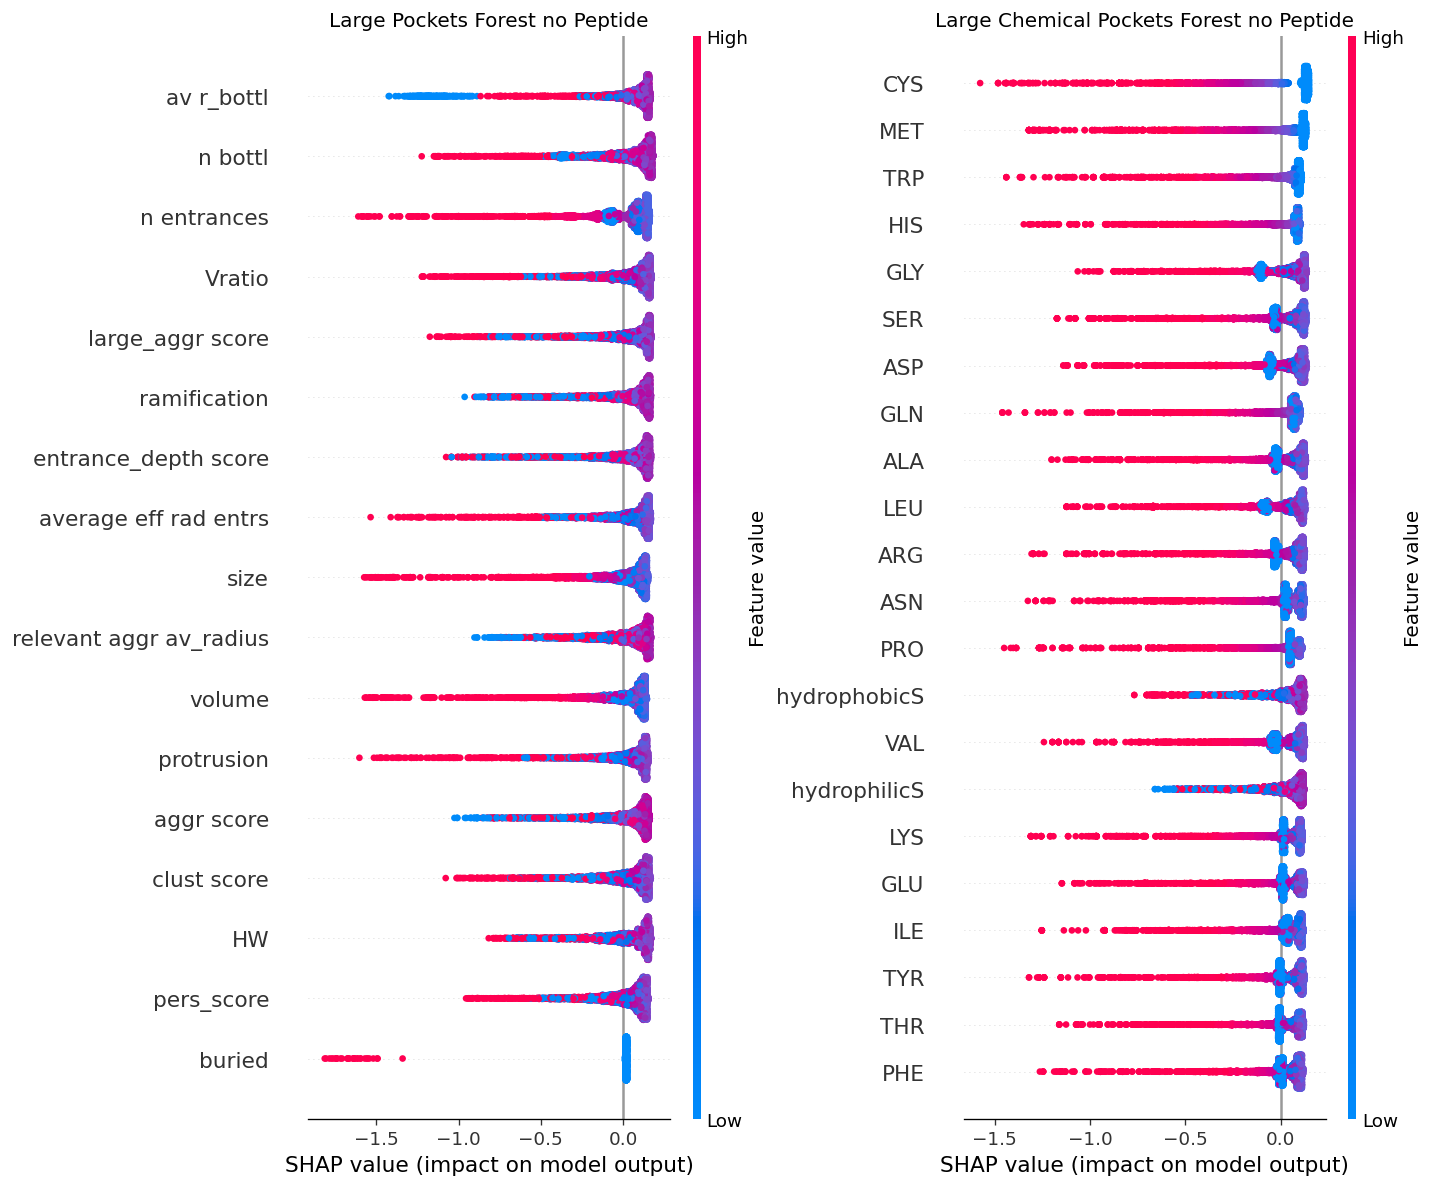

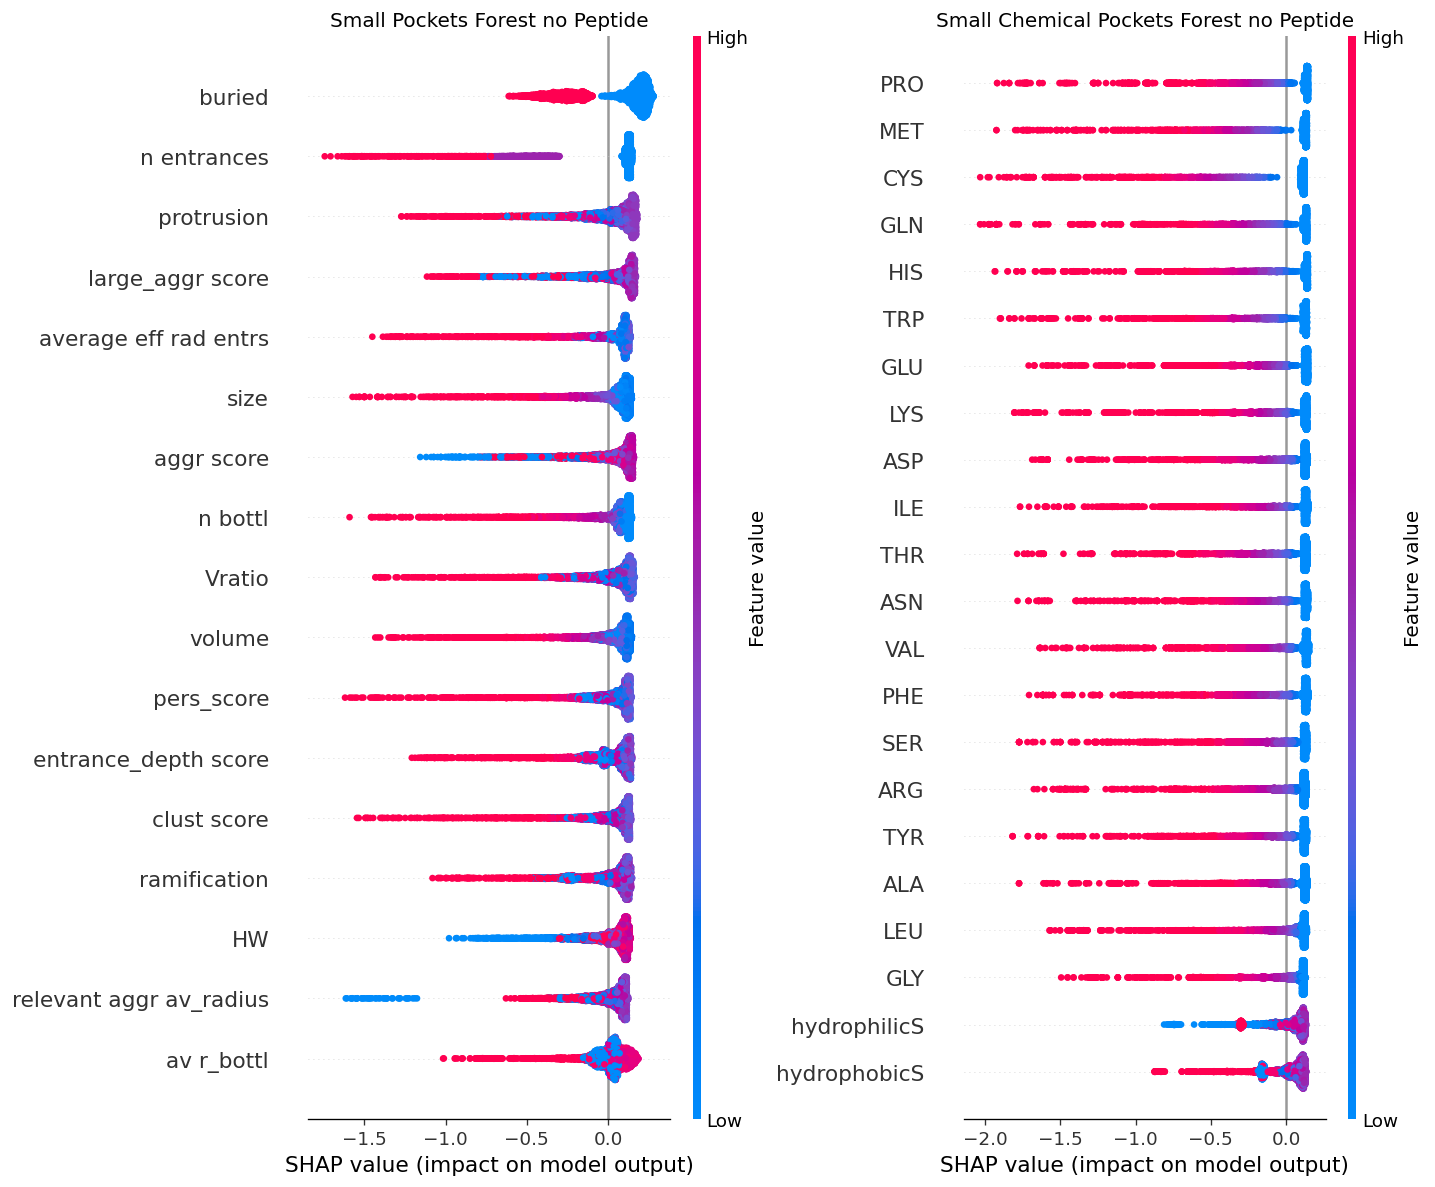

In [12]:
featNames = list(Xd_Noreplica_p[0].keys())
featNamesChem = list(Xd_Chem_Noreplica_p[0].keys())

plt.figure(figsize=(12,10),dpi= 120)
plt.subplot(1,2,1)
plt.title("Large Pockets Forest no Peptide")
shap.summary_plot(shap_values_L,feature_names=featNames,plot_size=None,show=False)#max_display=X_p.shape[1])

# plt.figure(figsize=(8,8),dpi= 150)
plt.subplot(1,2,2)
plt.title("Large Chemical Pockets Forest no Peptide")
shap.summary_plot(shap_values_chem,feature_names=featNamesChem,plot_size=None,show=False,max_display=X_chemExplainer.shape[1])
plt.tight_layout()
# plt.show()
plt.savefig("shapAnalysis_Large_NoPeptide.pdf")


plt.figure(figsize=(12,10),dpi= 120)
plt.subplot(1,2,1)
plt.title("Small Pockets Forest no Peptide")
shap.summary_plot(shap_values_S,feature_names=featNames,plot_size=None,show=False)#max_display=X_p.shape[1])

plt.subplot(1,2,2)
plt.title("Small Chemical Pockets Forest no Peptide")
shap.summary_plot(shap_values_chemS,feature_names=featNamesChem,plot_size=None,show=False,max_display=X_chemExplainer.shape[1])
plt.tight_layout()
# plt.show()
plt.savefig("shapAnalysis_Small_NoPeptide.pdf")

